```
BEGIN ASSIGNMENT
init_cell: false
export_cell: false
check_all_cell: false

generate:
    show_hidden: true
```

In [1]:
# This code sets up display options, imports, etc.
!pip install matplotlib_inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats

import plotly.express as px
import plotly.io as pio

# set up plotting defaults
%matplotlib inline
set_matplotlib_formats("svg")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (4, 3)
pio.templates.default = "simple_white"

# display options for numpy and pandas
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("precision", 2)

In [2]:
def display_df(
    df, rows=pd.options.display.max_rows, cols=pd.options.display.max_columns
):
    """Displays n rows and cols from df"""
    with pd.option_context("display.max_rows", rows, "display.max_columns", cols):
        display(df)

# Lab 4: Case Study on Air Quality

**Data Science Bootcamp with Python, Pandas, and Plotly**

Mar 14, 2023

## Part 1: Cleaning a US Sensor's Data

In [3]:
def data(csv):
    return f'https://github.com/DS-100/textbook/raw/master/content/datasets/purpleair_study/{csv}'

data('aqs_06-067-0010.csv')

'https://github.com/DS-100/textbook/raw/master/content/datasets/purpleair_study/aqs_06-067-0010.csv'

In [4]:
aqs = pd.read_csv(data('aqs_06-067-0010.csv'))
aqs.head(2)

,state_code,county_code,site_number,parameter_code,...,city,cbsa_code,cbsa,date_of_last_change
0,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
1,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24


In [5]:
display_df(aqs.iloc[0].to_frame(), rows=31)

,0
state_code,6
county_code,67
site_number,10
parameter_code,88101
poc,1
latitude,38.57
longitude,-121.49
datum,NAD83
parameter,PM2.5 - Local Conditions
sample_duration,24 HOUR


Data dictionary:

https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files

### What should we check about the data quality?

https://learningds.org/ch/09/wrangling_checks.html

In [16]:
## IGNORE ##

# Before we can use this data for analysis, we'll perform validity checks with a
# combination of EDA and visualization, then clean the data where necessary.

# We will:

# 1. Check and correct the granularity of the data.
# 1. Remove unneeded columns.
# 1. Check validity of the `date_local` column.
# 1. Check validity of the `arithmetic_mean` column.

# There are many more checks we could perform on this data. If we were planning
# to publish this work more broadly, we would be as thorough as possible.
# For the sake of brevity, we've chosen a few important validity checks that
# specifically reinforce ideas we've covered in data wrangling, EDA, and visualization.

### What's the Granularity?

In [6]:
aqs['date_local'].value_counts() # SOLUTION

2019-03-19    12
2019-08-25    12
2019-05-27    12
              ..
2019-09-24    12
2019-10-18    12
2019-01-30    12
Name: date_local, Length: 189, dtype: int64

In [7]:
one_date = (aqs.query('date_local == "2018-12-31"')
 [['date_local', 'pollutant_standard', 'event_type', 'arithmetic_mean']]
)
display_df(one_date, rows=12)

,date_local,pollutant_standard,event_type,arithmetic_mean
0,2018-12-31,PM25 24-hour 2006,None,3.1
1,2018-12-31,PM25 24-hour 2006,Included,3.1
140,2018-12-31,PM25 Annual 2006,None,3.1
141,2018-12-31,PM25 Annual 2006,Included,3.1
280,2018-12-31,PM25 24-hour 2012,None,3.1
281,2018-12-31,PM25 24-hour 2012,Included,3.1
420,2018-12-31,PM25 Annual 2012,None,3.1
421,2018-12-31,PM25 Annual 2012,Included,3.1
560,2018-12-31,PM25 24-hour 1997,None,3.1
561,2018-12-31,PM25 24-hour 1997,Included,3.1


In [8]:
# BEGIN SOLUTION
(aqs
 .groupby('date_local')
 ['arithmetic_mean']
 .agg(np.ptp) # np.ptp computes max() - min()
)
# For all 189 dates, the max PM2.5 - min PM2.5 is 0
# END SOLUTION

date_local
2018-05-20    0.0
2018-05-23    0.0
2018-05-29    0.0
             ... 
2019-12-23    0.0
2019-12-26    0.0
2019-12-29    0.0
Name: arithmetic_mean, Length: 189, dtype: float64

So, we can simply take the first PM2.5 measurement for each date.

In [9]:
# BEGIN SOLUTION
def rollup_dates(df):
    return (
        df.groupby('date_local')
        .first()
        .reset_index()
    )
# END SOLUTION

In [10]:
# BEGIN SOLUTION
aqs = (pd.read_csv(data('aqs_06-067-0010.csv'))
       .pipe(rollup_dates))
aqs.head(2)
# END SOLUTION

,date_local,state_code,county_code,site_number,...,city,cbsa_code,cbsa,date_of_last_change
0,2018-05-20,6,67,10,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
1,2018-05-23,6,67,10,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24


This data cleaning step gives us the desired granularity of `aqs`:
every row in `aqs` represents a single date, with an average PM2.5
measurement for that date.

## Removing Unneeded Columns

We plan to match the PM2.5 measurements in the `aqs` dataframe with
the PurpleAir PM2.5 measurements for each date.
To simplify the data, we'll subset out the date and PM2.5 columns and rename the
PM2.5 column so that it's easier to understand.

In [11]:
# BEGIN SOLUTION
# If time allows, this would be a short You Try activity
def subset_cols(df):
    subset = df[['date_local', 'arithmetic_mean']]
    return subset.rename(columns={'arithmetic_mean': 'pm25'})
# END SOLUTION

In [12]:
# BEGIN SOLUTION
aqs = (pd.read_csv(data('aqs_06-067-0010.csv'))
       .pipe(rollup_dates)
       .pipe(subset_cols))
aqs
# END SOLUTION

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
...,...,...
186,2019-12-23,5.7
187,2019-12-26,2.0
188,2019-12-29,19.5


## Checking the Validity of `date_local`

Let's take a closer look at the `date_local` column.
We can already see that there are gaps in dates where there are no
PM2.5 readings.

In [13]:
# The table is sorted by `date_local`, so we see that there are missing dates
# between 2018-05-20 and 2018-05-23, for example.
aqs

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
...,...,...
186,2019-12-23,5.7
187,2019-12-26,2.0
188,2019-12-29,19.5


In [14]:
# Python strings are recorded as the `object` type in pandas
aqs.dtypes

date_local     object
pm25          float64
dtype: object

In [15]:
aqs['date_local'].iloc[0]

'2018-05-20'

In [16]:
# BEGIN SOLUTION
# This is the Python representation of the YYYY-MM-DD format
date_format = '%Y-%m-%d'

pd.to_datetime(aqs['date_local'], format=date_format)
# END SOLUTION

0     2018-05-20
1     2018-05-23
2     2018-05-29
         ...    
186   2019-12-23
187   2019-12-26
188   2019-12-29
Name: date_local, Length: 189, dtype: datetime64[ns]

In [17]:
# BEGIN SOLUTION
def parse_dates(df):
    date_format = '%Y-%m-%d'
    timestamps = pd.to_datetime(df['date_local'], format=date_format)
    return df.assign(date_local=timestamps)
# END SOLUTION

In [32]:
# BEGIN SOLUTION
aqs = (pd.read_csv(data('aqs_06-067-0010.csv'))
       .pipe(rollup_dates)
       .pipe(subset_cols)
       .pipe(parse_dates))
aqs
# END SOLUTION

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
...,...,...
186,2019-12-23,5.7
187,2019-12-26,2.0
188,2019-12-29,19.5


In [29]:
aqs.dtypes

date_local    datetime64[ns]
pm25                 float64
dtype: object

Now that the `date_local` contains timestamps, we can calculate how
many dates are missing. We'll find the number of days between the earliest and
latest date---this corresponds to the maximum number of measurements we could
have recorded.

In [35]:
date_range = aqs['date_local'].max() - aqs['date_local'].min()
date_range

Timedelta('588 days 00:00:00')

In [36]:
# Subtracting timestamps give Timedelta objects, which have a few useful
# properties like:
date_range.days

588

In [39]:
print(f'We have {len(aqs)} / {date_range.days} measurements, '
      f'or {len(aqs) / date_range.days:.0%} of the dates possible.')

We have 189 / 588 measurements, or 32% of the dates possible.


### Checking the Validity of `pm25`

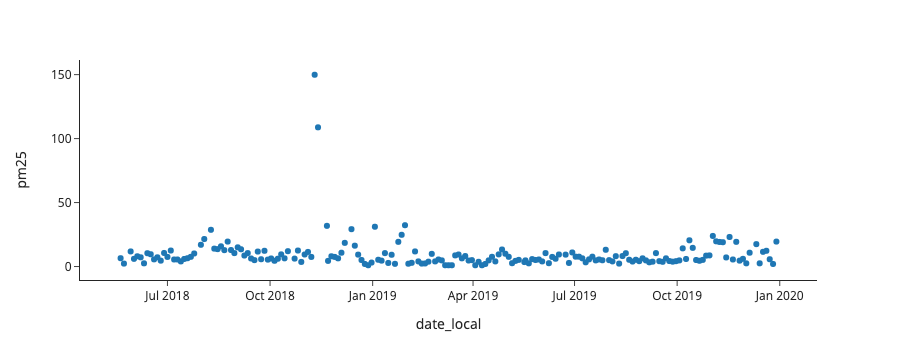

In [30]:
px.scatter(aqs, x='date_local', y='pm25');

## End of Part 1!

## Part 2: Cleaning a PurpleAir Sensor's Data

In [33]:
pa_raw = pd.read_csv(data('purpleair_AMTS/AMTS_TESTING%20(outside)%20(38.568404%20-121.493163)%20Primary%20Real%20Time%2005_20_2018%2012_29_2019.csv'))
pa_raw

,created_at,entry_id,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,...,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3,Unnamed: 10
0,2018-05-20 00:00:35 UTC,20733,0.98,1.23,...,83.0,32.0,1.23,NaN
1,2018-05-20 00:01:55 UTC,20734,0.96,1.94,...,83.0,32.0,1.94,NaN
2,2018-05-20 00:03:15 UTC,20735,1.07,1.80,...,83.0,32.0,1.80,NaN
...,...,...,...,...,...,...,...,...,...
672752,2019-12-29 23:55:30 UTC,523358,24.44,40.45,...,52.0,67.0,36.91,NaN
672753,2019-12-29 23:57:30 UTC,523359,23.69,37.72,...,58.0,67.0,35.49,NaN
672754,2019-12-29 23:59:30 UTC,523360,24.60,37.57,...,58.0,66.0,35.33,NaN


In [34]:
display_df(pa_raw.iloc[0].to_frame().reset_index(), rows=11)

,index,0
0,created_at,2018-05-20 00:00:35 UTC
1,entry_id,20733
2,PM1.0_CF1_ug/m3,0.98
3,PM2.5_CF1_ug/m3,1.23
4,PM10.0_CF1_ug/m3,1.23
5,UptimeMinutes,2299.0
6,RSSI_dbm,-62.0
7,Temperature_F,83.0
8,Humidity_%,32.0
9,PM2.5_ATM_ug/m3,1.23


There are two columns that
contain PM2.5 data: `PM2.5_CF1_ug/m3` and `PM2.5_ATM_ug/m3`.
We'll keep `PM2.5_CF1_ug/m3` since the original researchers found that feature to be
more effective.

In [35]:
def subset_and_rename_A(df):
    df = df[['created_at', 'PM2.5_CF1_ug/m3', 'Temperature_F', 'Humidity_%']]
    df.columns = ['timestamp', 'PM25cf1', 'TempF',
                  'RH'] # RH stands for Relative Humidity
    return df

pa = (pa_raw
      .pipe(subset_and_rename_A))
pa

,timestamp,PM25cf1,TempF,RH
0,2018-05-20 00:00:35 UTC,1.23,83.0,32.0
1,2018-05-20 00:01:55 UTC,1.94,83.0,32.0
2,2018-05-20 00:03:15 UTC,1.80,83.0,32.0
...,...,...,...,...
672752,2019-12-29 23:55:30 UTC,40.45,52.0,67.0
672753,2019-12-29 23:57:30 UTC,37.72,58.0,67.0
672754,2019-12-29 23:59:30 UTC,37.57,58.0,66.0


### What's the Granularity?

In [8]:
pa.head(2)

,timestamp,PM25cf1,TempF,RH
0,2018-05-20 00:00:35 UTC,1.23,83.0,32.0
1,2018-05-20 00:01:55 UTC,1.94,83.0,32.0


In [36]:
# BEGIN SOLUTION
date_format = '%Y-%m-%d %X %Z'
times = pd.to_datetime(pa['timestamp'], format=date_format)
times
# END SOLUTION

0        2018-05-20 00:00:35+00:00
1        2018-05-20 00:01:55+00:00
2        2018-05-20 00:03:15+00:00
                    ...           
672752   2019-12-29 23:55:30+00:00
672753   2019-12-29 23:57:30+00:00
672754   2019-12-29 23:59:30+00:00
Name: timestamp, Length: 672755, dtype: datetime64[ns, UTC]

In [38]:
# BEGIN SOLUTION
def parse_timestamps(df):
    date_format = '%Y-%m-%d %X %Z'
    times = pd.to_datetime(df['timestamp'], format=date_format)
    return (df.assign(timestamp=times)
            .set_index('timestamp'))

pa = (pa_raw
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps))
pa.head(2)
# END SOLUTION

,PM25cf1,TempF,RH
timestamp,,,
2018-05-20 00:00:35+00:00,1.23,83.0,32.0
2018-05-20 00:01:55+00:00,1.94,83.0,32.0


Need to adjust for timezone!

In [39]:
# https://pvlib-python.readthedocs.io/en/stable/timetimezones.html
# The US/Pacific timezone corresponds to the timezone in California, and will
# automatically adjust for Daylight Saving Time.
pa.tz_convert('US/Pacific')

,PM25cf1,TempF,RH
timestamp,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0
2018-05-19 17:01:55-07:00,1.94,83.0,32.0
2018-05-19 17:03:15-07:00,1.80,83.0,32.0
...,...,...,...
2019-12-29 15:55:30-08:00,40.45,52.0,67.0
2019-12-29 15:57:30-08:00,37.72,58.0,67.0
2019-12-29 15:59:30-08:00,37.57,58.0,66.0


In [40]:
# BEGIN SOLUTION
def convert_tz(pa):
    return pa.tz_convert('US/Pacific')

pa = (pa_raw
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps)
      .pipe(convert_tz))
pa.head(2)
# END SOLUTION

,PM25cf1,TempF,RH
timestamp,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0
2018-05-19 17:01:55-07:00,1.94,83.0,32.0


### Visualizing Timestamps

In [41]:
# The 'D' argument tells resample to aggregate timestamps into individual dates
(pa.resample('D')
 .size() # We can call aggregation methods just like we would with `groupby()`
)

timestamp
2018-05-19 00:00:00-07:00     315
2018-05-20 00:00:00-07:00    1079
2018-05-21 00:00:00-07:00    1074
                             ... 
2019-12-27 00:00:00-08:00    1440
2019-12-28 00:00:00-08:00    1200
2019-12-29 00:00:00-08:00     480
Freq: D, Length: 590, dtype: int64

In [48]:
per_day = (pa
 .resample('D')
 .size()
 .rename('# measurements')
 .reset_index()
)
per_day

,timestamp,# measurements
0,2018-05-19 00:00:00-07:00,315
1,2018-05-20 00:00:00-07:00,1079
2,2018-05-21 00:00:00-07:00,1074
...,...,...
587,2019-12-27 00:00:00-08:00,1440
588,2019-12-28 00:00:00-08:00,1200
589,2019-12-29 00:00:00-08:00,480


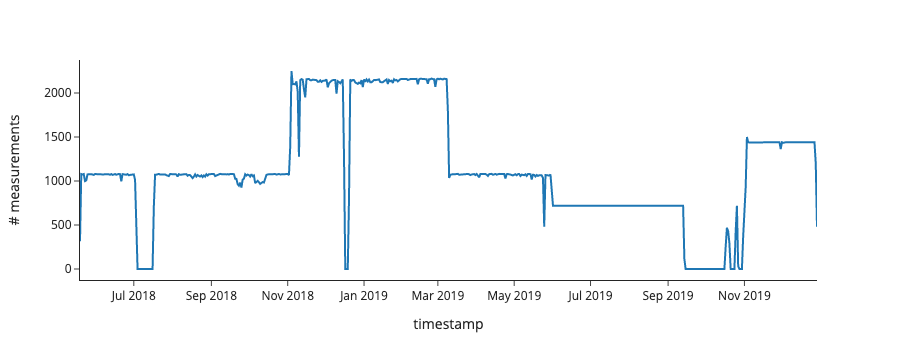

In [49]:
px.line(per_day, x='timestamp', y='# measurements')

PurpleAir says that its sensors take a recording every 2 minutes. What's weird about this plot?

#### Why is the Sampling Rate Inconsistent?

In [71]:
# Passing a string into .loc will filter timestamps
pa.loc['2019-01-01'] # SOLUTION

,PM25cf1,TempF,RH
timestamp,,,
2019-01-01 00:00:17-08:00,0.61,50.0,28.0
2019-01-01 00:01:40-08:00,0.53,50.0,28.0
2019-01-01 00:02:57-08:00,0.40,50.0,28.0
...,...,...,...
2019-01-01 23:56:51-08:00,55.83,44.0,62.0
2019-01-01 23:58:19-08:00,60.64,44.0,61.0
2019-01-01 23:59:29-08:00,60.82,44.0,62.0


In [19]:
pa.loc['2019-01-01 00:00']

,PM25cf1,TempF,RH
timestamp,,,
2019-01-01 00:00:17-08:00,0.61,50.0,28.0
2019-01-01 00:00:17-08:00,0.61,50.0,28.0


In [18]:
pa.loc['2019-01-01'].index.value_counts() # SOLUTION

2019-01-01 00:00:17-08:00    2
2019-01-01 16:08:39-08:00    2
2019-01-01 15:49:59-08:00    2
                            ..
2019-01-01 08:12:08-08:00    2
2019-01-01 08:13:28-08:00    2
2019-01-01 23:59:29-08:00    2
Name: timestamp, Length: 1077, dtype: int64

In [72]:
# BEGIN SOLUTION
def drop_duplicate_rows(df):
    return df[~df.index.duplicated()]

pa = (pa_raw
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps)
      .pipe(convert_tz)
      .pipe(drop_duplicate_rows))
pa.head(2)
# END SOLUTION

,PM25cf1,TempF,RH
timestamp,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0
2018-05-19 17:01:55-07:00,1.94,83.0,32.0


In [73]:
per_day = (pa
 .resample('D')
 .size()
 .rename('# measurements')
 .reset_index()
)
per_day

,timestamp,# measurements
0,2018-05-19 00:00:00-07:00,315
1,2018-05-20 00:00:00-07:00,1079
2,2018-05-21 00:00:00-07:00,1074
...,...,...
587,2019-12-27 00:00:00-08:00,720
588,2019-12-28 00:00:00-08:00,720
589,2019-12-29 00:00:00-08:00,480


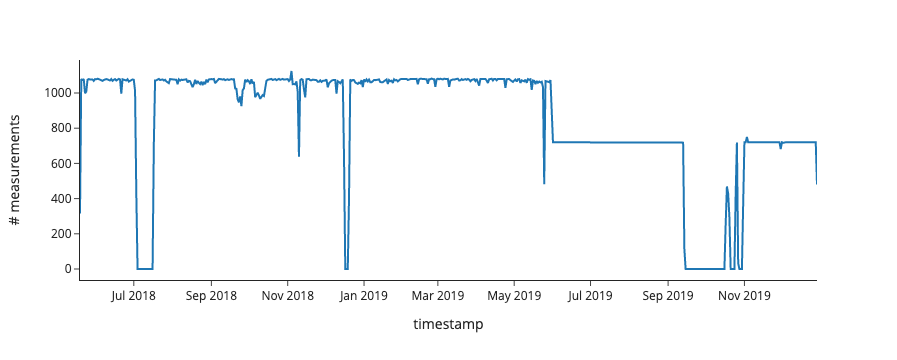

In [74]:
px.line(per_day, x='timestamp', y='# measurements')

### You Try: What do we do About Missing Data?

In [ ]:
## IGNORE ##

# We'll follow Barkjohn's
# original analysis: we only keep a 24-hour average if there are at least 90%
# of the possible points for that day. We'll need to remember that
# before May 30, 2019 there are 1080 possible points in a day---after May 30,
# there are 720 points possible.

## Part 3: Exploring the Sensor Pair's Data

What aspects of this data can we explore?

In [88]:
## IGNORE ##

# Show how AQS and PA vary with each other over time and via scatter plot

In [80]:
csv_file = 'data/cleaned_purpleair_aqs/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'TempC', 'RH', 'Dewpoint']

full_df = (pd.read_csv(data('cleaned_purpleair_aqs/Full24hrdataset.csv'),
                       usecols=usecols, parse_dates=['Date'])
           .dropna())
full_df.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'temp', 'rh', 'dew']
full_df

,date,id,region,pm25aqs,pm25pa,temp,rh,dew
0,2019-05-17,AK1,Alaska,6.7,8.62,18.03,38.56,3.63
1,2019-05-18,AK1,Alaska,3.8,3.49,16.12,49.40,5.44
2,2019-05-21,AK1,Alaska,4.0,3.80,19.90,29.97,1.73
...,...,...,...,...,...,...,...,...
12427,2019-02-20,WI6,North,15.6,25.30,1.71,65.78,-4.08
12428,2019-03-04,WI6,North,14.0,8.21,-14.38,48.21,-23.02
12429,2019-03-22,WI6,North,5.8,9.44,5.08,52.20,-4.02


| Column  | Description                                                                                                                      |
|---------|----------------------------------------------------------------------------------------------------------------------------------|
| date    | Date of the observation                                                                                                          |
| id      | A unique label for a site, formatted as the US state abbreviation with a number. (We performed data cleaning for site ID `CA1`.) |
| region  | The name of the region, which corresponds to a group of sites. (The `CA1` site is located in the `West` region.)                 |
| pm25aqs | The PM2.5 measurement from the AQS sensor.                                                                                       |
| pm25pa  | The PM2.5 measurement from the PurpleAir sensor.                                                                                 |
| temp    | Temperature, in Celcius.                                                                                                         |
| rh      | Relative humidity, ranging from 0 to 100%.                                                                                       |
| dew     | The dew point. (Higher dew point means more moisture in the air.)                                                     |

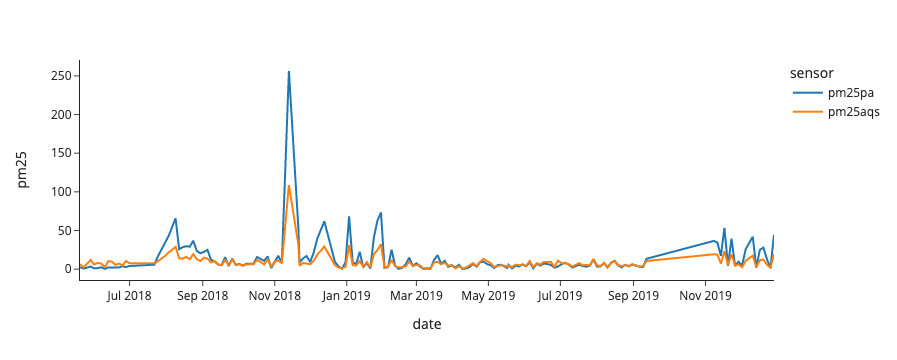

In [87]:
df = (full_df
 .query('id == "CA1"')
 .melt(['date'], ['pm25aqs', 'pm25pa'], var_name='sensor', value_name='pm25')
 .sort_values('date')
)
px.line(df, x='date', y='pm25', color='sensor')

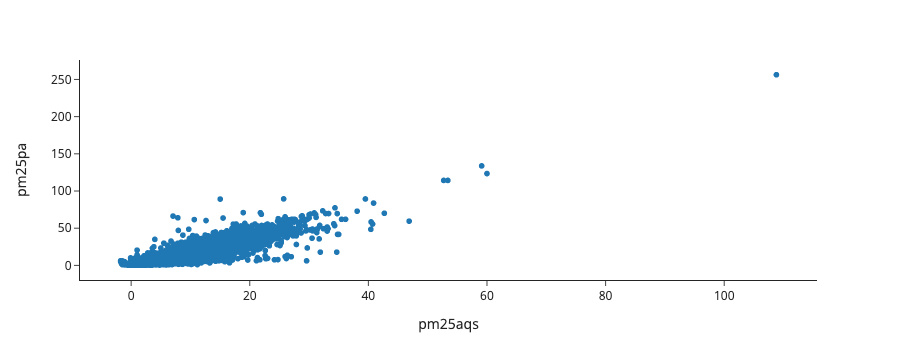

In [90]:
px.scatter(full_df, x='pm25aqs', y='pm25pa')

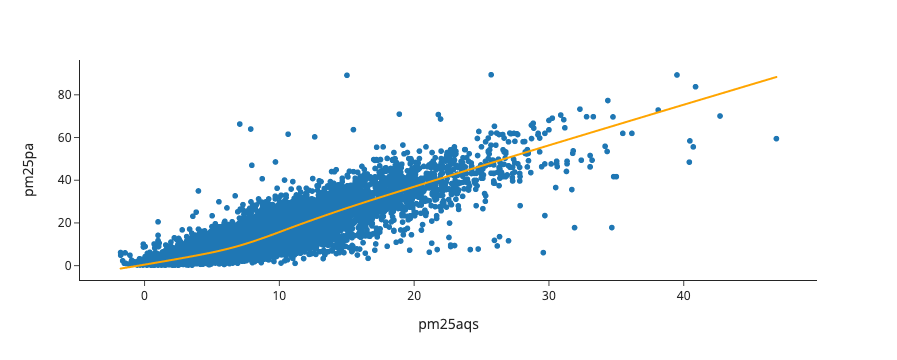

In [94]:
under_50 = full_df[full_df['pm25aqs'] < 50]
px.scatter(under_50, x='pm25aqs', y='pm25pa',
           trendline='lowess',
           trendline_color_override="orange")

In [96]:
full_df[['pm25aqs', 'pm25pa']].corr()

,pm25aqs,pm25pa
pm25aqs,1.00,0.88
pm25pa,0.88,1.00


## Part 4: Modeling the Difference between US and PurpleAir

Don't worry about the code below, I'll explain as we go.

In [105]:
np.random.seed(42)

n = len(full_df)
test_n = 1000

# Shuffle the row labels
shuffled = np.random.choice(n, size=n, replace=False)

# Split the data
test  = full_df.iloc[shuffled[:test_n]]
train = full_df.iloc[shuffled[test_n:]]
train

,date,id,region,pm25aqs,pm25pa,temp,rh,dew
2685,2019-04-25,CA2,West,7.17,8.06,22.99,48.33,11.46
10214,2018-08-30,NC4,Southeast,12.60,23.13,33.01,46.22,19.98
10516,2019-08-14,VT1,North,6.78,8.70,25.44,49.25,14.01
...,...,...,...,...,...,...,...,...
5402,2019-10-10,GA1,Southeast,6.70,11.99,23.52,60.24,15.35
861,2019-01-31,AZ1,Central Southwest,9.40,10.98,20.90,29.33,2.31
7282,2018-08-10,IA2,North,18.67,43.22,29.60,50.17,18.15


In [103]:
def rmse(predictions):
    return np.sqrt(np.mean((test['pm25aqs'] - predictions)**2))

In [104]:
def model_results(models):
    results = [
        [model.__doc__, rmse(model(train)(test))]
        for model in models
    ]
    return (pd.DataFrame(results, columns=['model', 'rmse'])
            .set_index('model'))

### One-variable model (simple linear regression)

In [106]:
from sklearn.linear_model import LinearRegression

def model_1(train):
    '''f(x) = θ₀ + θ₁PA'''
    # Fit calibration model using sklearn
    X, y = train[['pm25aqs']], train['pm25pa']
    model = LinearRegression().fit(X, y)
    m, b = model.coef_[0], model.intercept_
    
    # Invert model
    theta_1 = 1 / m
    theta_0 = - b / m
    
    def predict(data):
        return theta_0 + theta_1 * data['pm25pa']
    return predict

In [107]:
model_results([model_1])

,rmse
model,
f(x) = θ₀ + θ₁PA,2.96


Under this model, $ \hat \theta_1 = 0.52 $ and $ \hat \theta_0 = 1.54 $, so our
fitted model predicts:

$$
\begin{aligned}
\text{PM}_{2.5} = 1.54 + 0.52 \text{PA}
\end{aligned}
$$

### Model with both PurpleAir and Relative Humidity

In [108]:
def model_2(train):
    '''f(x) = θ₀ + θ₁PA + θ₂RH'''
    # Fit calibration model using sklearn
    X, y = train[['pm25aqs', 'rh']], train['pm25pa']
    model = LinearRegression().fit(X, y)
    [m1, m2], b = model.coef_, model.intercept_
    
    # Invert to find parameters
    theta_0 = - b / m1
    theta_1 = 1 / m1
    theta_2 = - m2 / m1
    
    def predict(data):
        return theta_0 + theta_1 * data['pm25pa'] + theta_2 * data['rh']
        return (data['pm25pa'] - data['rh'] * m2 - b) / m1
    return predict

In [109]:
model_results([model_1, model_2])

,rmse
model,
f(x) = θ₀ + θ₁PA,2.96
f(x) = θ₀ + θ₁PA + θ₂RH,2.58


After fitting the model, we have:
$ \hat \theta_0 = 5.77 $, $ \hat \theta_1 = 0.524 $, and
$ \hat \theta_2 = -0.0860 $
so our fitted model predicts:

$$
\begin{aligned}
\text{PM}_{2.5} = 5.77 + 0.524 \cdot \text{PA} - 0.086 \cdot \text{RH}
\end{aligned}
$$